# Notebook 8: Test ikarus and XGBoost models with swapped features
Question: Does swapping feature sets affect performance for ikarus and XGBoost models?

Tested the following:
* ikarus model using top 200 DGEs for our model
* XGBoost model using ikarus gene signatures (identified from training set)

Code uses 6_ikarus.ipynb and [ikarus tutorial](https://github.com/BIMSBbioinfo/ikarus/blob/master/tutorials/tutorial.ipynb) as references

In [1]:
import main_functions as mf
from pathlib import Path
import os
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
from ikarus import classifier, gene_list, utils, data
import upsetplot
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedGroupKFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

/home/gylam/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up working directory
folder_path = input('Please enter the path of the folder containing datasets: ')
os.chdir(folder_path)

Please enter the path of the folder containing datasets:  ../data/


In [3]:
# Constants and global variables
RANDOM_STATE = 42
metrics_df_models = pd.DataFrame()
baseline_ikarus_path = '../out/train_ikarus_baseline/'
dge_ikarus_path = '../out/train_ikarus_dge/'

In [4]:
# Load training and two test sets
adatas = {}

train_adata = sc.read_h5ad('train.h5ad')
train_adata.obs['CellType'] = np.where(train_adata.obs.orig_cancer_label == 1, 'Cancer', 'Other')
train_adata.var['gene_symbol'] = train_adata.var.gene_ids
adatas['train'] = train_adata

# Load in test sets 1 and 2
test1_adata = sc.read_h5ad('test1.h5ad')
test1_adata.obs['CellType'] = np.where(test1_adata.obs.orig_cancer_label == 1, 'Cancer', 'Other')
test1_adata.var['gene_symbol'] = test1_adata.var.gene_ids

test2_adata = sc.read_h5ad('test2.h5ad')
test2_adata.obs['CellType'] = np.where(test2_adata.obs.orig_cancer_label == 1, 'Cancer', 'Other')
test2_adata.var['gene_symbol'] = test2_adata.var.gene_ids

adatas['test1'] = test1_adata
adatas['test2'] = test2_adata

In [5]:
# If ikarus gene signature does not exist, create
signatures_path_ikarus = Path(baseline_ikarus_path + 'signatures.gmt')

if not signatures_path_ikarus.is_file():

    # Set up gene lists fo cancer and normal
    dfs = [train_adata]
    names = ['train']
    obs_names = ['CellType']
    label_upregs = ['Cancer']
    label_downregs = ['Other']
    
    signatures_cancer = gene_list.create_all(
        label_upregs_list=label_upregs,
        label_downregs_list=label_downregs,
        adatas_dict=adatas,
        names_list=names,
        obs_names_list=obs_names,
        integration_fun=utils.intersection_fun,
        top_x=300
    )
    
    signatures_norm = gene_list.create_all(
        label_upregs_list=label_downregs,
        label_downregs_list=label_upregs,
        adatas_dict=adatas,
        names_list=names,
        obs_names_list=obs_names,
        integration_fun=utils.intersection_fun,
        top_x=300
    )
    
    # Get lists of tumor and normal genes from ikarus signature (generated with Qian dataset)
    contents_cancer = upsetplot.from_contents(signatures_cancer)
    contents_norm = upsetplot.from_contents(signatures_norm)
    
    tumor_genes = contents_cancer['id'].values.ravel().tolist()
    normal_genes = contents_norm['id'].values.ravel().tolist()
    print(f'num tumor_genes: {len(tumor_genes)}, num normal_genes: {len(normal_genes)}')
    overlap = list(set(tumor_genes).union(normal_genes))
    print(len(overlap)) # Equals sum of tumor_genes and normal_genes, so no overlap
    
    # Save signatures as .gmt file
    gene_list.save_gmt([normal_genes, tumor_genes], ['Normal', 'Tumor'],
                       out_dir=baseline_ikarus_path)

In [6]:
# If gene signature of DGEs doesn't exist, create signature
signatures_path_dge = Path(dge_ikarus_path + 'signatures.gmt')

if not Path(signatures_path_dge).is_file():
    # Get top 200 DGEs from training data - 2 lists
    Path(dge_ikarus_path).mkdir(exist_ok=True)
    cancer_dge, norm_dge = mf.get_diff_exp_genes(train_adata)
    cancer_dge_top100 = cancer_dge[:100]
    norm_dge_top100 = norm_dge[:100]
    model_dge_top200  = list(set(cancer_dge_top100).union(norm_dge_top100))

    # Remove overlapping genes
    normal_genes_final = list(set(norm_dge_top100) - set(model_dge_top200))
    
    # Save DGE signature as .gmt file.
    gene_list.save_gmt([normal_genes_final, cancer_dge_top100],
                       ['Normal', 'Tumor'],
                       out_dir=dge_ikarus_path)

In [7]:
# Run baseline ikarus - confirms similar results as 6_ikarus.ipynb
# Train with training set, using features from ikarus approach

model_qian_ikarus = classifier.Ikarus(signatures_gmt=signatures_path_ikarus,
                                      out_dir=baseline_ikarus_path,
                                      adapt_signatures = True)

train_adata_list = [adatas['train']]
train_names_list = ['train']
obs_columns_list = ['orig_cancer_label']

model_qian_ikarus.fit(train_adata_list, train_names_list, obs_columns_list, save=True)

# Run on test sets 1 and 2

ikarus_baseline_test1 = model_qian_ikarus.predict(test1_adata, 'test1', save=True)
y_test1 = test1_adata.obs.orig_cancer_label
y_pred1 = np.where(ikarus_baseline_test1 == 'Tumor', 1, 0)
ikarus_baseline_metrics1, ikarus_baseline_cm1 = mf.calc_eval_metrics(
                                                    y_test1, y_pred1, 'ikarus', 'ikarus', 
                                                    'yes', 'test1')

ikarus_baseline_test2 = model_qian_ikarus.predict(test2_adata, 'test2', save=True)
y_test2 = test2_adata.obs.orig_cancer_label
y_pred2 = np.where(ikarus_baseline_test2 == 'Tumor', 1, 0)
ikarus_baseline_metrics2, ikarus_baseline_cm2 = mf.calc_eval_metrics(
                                                    y_test2, y_pred2,'ikarus', 'ikarus', 
                                                    'yes', 'test2')

# Save metrics to metrics_df_models
metrics_df_models = pd.concat([metrics_df_models, ikarus_baseline_metrics1])
metrics_df_models = pd.concat([metrics_df_models, ikarus_baseline_metrics2])

Less than 80% of signature genes are available in data set. A temporary signature is stored where non-overlapping genes are removed. It is proceeded with the temporary signature.
Less than 80% of signature genes are available in data set. A temporary signature is stored where non-overlapping genes are removed. It is proceeded with the temporary signature.


/home/gylam/.local/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/home/gylam/.local/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


converged at iteration step: 30 with 0.0010 < 0.001
Less than 80% of signature genes are available in data set. A temporary signature is stored where non-overlapping genes are removed. It is proceeded with the temporary signature.
Less than 80% of signature genes are available in data set. A temporary signature is stored where non-overlapping genes are removed. It is proceeded with the temporary signature.


/home/gylam/.local/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/home/gylam/.local/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


converged at iteration step: 45 with 0.0009 < 0.001


In [8]:
# Run ikarus using our model's DGE gene signature
model_qian_dge = classifier.Ikarus(signatures_gmt=signatures_path_dge,
                                   out_dir=dge_ikarus_path, adapt_signatures = True)

model_qian_dge.fit(train_adata_list, train_names_list, obs_columns_list, save=True)

# Run on test sets 1 and 2 - compare with Bryan's results

model_val_test1 = model_qian_dge.predict(test1_adata, 'test1', save=True)
y_test1 = test1_adata.obs.orig_cancer_label
y_pred1 = np.where(model_val_test1 == 'Tumor', 1, 0)
ikarus_dge_metrics1, ikarus_dge_cm1 = mf.calc_eval_metrics(y_test1, y_pred1,
                                                        'ikarus', 'dge', 
                                                        'yes', 'test1')

model_val_test2 = model_qian_dge.predict(test2_adata, 'test2', save=True)
y_test2 = test2_adata.obs.orig_cancer_label
y_pred2 = np.where(model_val_test2 == 'Tumor', 1, 0)
ikarus_dge_metrics2, ikarus_dge_cm2 = mf.calc_eval_metrics(y_test2, y_pred2,
                                                        'ikarus', 'dge', 
                                                        'yes', 'test2')

metrics_df_models = pd.concat([metrics_df_models, ikarus_dge_metrics1])
metrics_df_models = pd.concat([metrics_df_models, ikarus_dge_metrics2])

/home/gylam/.local/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/home/gylam/.local/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


converged at iteration step: 7 with 0.0008 < 0.001


/home/gylam/.local/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/home/gylam/.local/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


converged at iteration step: 8 with 0.0004 < 0.001


# Test our model using ikarus gene signature (using training set)

In [9]:
# Get genes from ikarus signature
ikarus_genes = mf.get_feat_from_gene_sig(signatures_path_ikarus)

# Get genes from DGE signature
dge_genes = mf.get_feat_from_gene_sig(signatures_path_dge)

In [10]:
# Concatenate all datasets to create a dataframe with all the same features (for training and testing purposes)
X1, X2, X3 = adatas['train'].to_df(), adatas['test1'].to_df(), adatas['test2'].to_df()
concat = pd.concat([X1,X2,X3]).fillna(0)

# Extracting relevant columns from concatenated dataset
X1 = concat.iloc[0:len(X1)]
X2 = concat.iloc[len(X1):len(X1)+len(X2)]
X3 = concat.iloc[len(X1)+len(X2):len(X1)+len(X2)+len(X3)]

y1 = adatas['train'].obs.orig_cancer_label
y2 = adatas['test1'].obs.orig_cancer_label
y3 = adatas['test2'].obs.orig_cancer_label

groups = adatas['train'].obs.PatientNumber
group_kfold = StratifiedGroupKFold(n_splits=5) #Using stratified K-fold to make sure labels are stratified
cv = group_kfold.get_n_splits(X1,y1, groups)

# Creating predictions dataframes to export later
test1_pred = pd.DataFrame()
test2_pred = pd.DataFrame()

In [11]:
# Run XGBoost with DGE features
clf_dge = XGBClassifier(eta = 0.3, max_depth = 3, n_estimators = 200, random_state = RANDOM_STATE) 

xgboost_dge_metrics1, xgboost_dge_cm1 = mf.train_test_model(clf_dge, X1, y1, X2, y2, dge_genes)
xgboost_dge_metrics1['model'] = 'xgboost'
xgboost_dge_metrics1['feat_set'] = 'dge'
xgboost_dge_metrics1['network_prop'] = 'no'
xgboost_dge_metrics1['dataset'] = 'test1'

xgboost_dge_metrics2, xgboost_dge_cm2 = mf.train_test_model(clf_dge, X1, y1, X3, y3, dge_genes)
xgboost_dge_metrics2['model'] = 'xgboost'
xgboost_dge_metrics2['feat_set'] = 'dge'
xgboost_dge_metrics2['network_prop'] = 'no'
xgboost_dge_metrics2['dataset'] = 'test2'

metrics_df_models = pd.concat([metrics_df_models, xgboost_dge_metrics1])
metrics_df_models = pd.concat([metrics_df_models, xgboost_dge_metrics2])

# cells in training: 33043, # cells in test: 10359
[[3611  359]
 [  40 6349]]


,recall,precision,f1,accuracy
0,0.994,0.946,0.97,0.961


# cells in training: 33043, # cells in test: 9856
[[7625  458]
 [  16 1757]]


,recall,precision,f1,accuracy
0,0.991,0.793,0.881,0.952


In [12]:
# Run XGBoost model using DGE hyperparameters on the two test sets
xgboost_ikarus_metrics1, xgboost_ikarus_cm1 = mf.train_test_model(clf_dge, X1, y1, X2, y2, ikarus_genes)
xgboost_ikarus_metrics1['model'] = 'xgboost'
xgboost_ikarus_metrics1['feat_set'] = 'ikarus'
xgboost_ikarus_metrics1['network_prop'] = 'no'
xgboost_ikarus_metrics1['dataset'] = 'test1'

xgboost_ikarus_metrics2, xgboost_ikarus_cm2 = mf.train_test_model(clf_dge, X1, y1, X3, y3, ikarus_genes)
xgboost_ikarus_metrics2['model'] = 'xgboost'
xgboost_ikarus_metrics2['feat_set'] = 'ikarus'
xgboost_ikarus_metrics2['network_prop'] = 'no'
xgboost_ikarus_metrics2['dataset'] = 'test2'

metrics_df_models = pd.concat([metrics_df_models, xgboost_ikarus_metrics1])
metrics_df_models = pd.concat([metrics_df_models, xgboost_ikarus_metrics2])


# cells in training: 33043, # cells in test: 10359
[[3533  437]
 [ 102 6287]]


,recall,precision,f1,accuracy
0,0.984,0.935,0.959,0.948


# cells in training: 33043, # cells in test: 9856
[[7766  317]
 [  20 1753]]


,recall,precision,f1,accuracy
0,0.989,0.847,0.912,0.966


In [13]:
# Get metrics without network propagation for ikarus

# Baseline ikarus
y_test1 = test1_adata.obs.orig_cancer_label
y_pred1 = pd.read_csv(baseline_ikarus_path + 'test1/prediction.csv', index_col = 0)['core_pred']
ikarus_baseline_metrics1, ikarus_baseline_cm1 = mf.calc_eval_metrics(
                                                    y_test1, y_pred1, 'ikarus',
                                                    'ikarus', 'no', 'test1')

y_test2 = test2_adata.obs.orig_cancer_label
y_pred2 = pd.read_csv(baseline_ikarus_path + 'test2/prediction.csv', index_col = 0)['core_pred']
ikarus_baseline_metrics2, ikarus_baseline_cm2 = mf.calc_eval_metrics(
                                                    y_test2, y_pred2, 'ikarus',
                                                    'ikarus', 'no', 'test2')
metrics_df_models = pd.concat([metrics_df_models, ikarus_baseline_metrics1])
metrics_df_models = pd.concat([metrics_df_models, ikarus_baseline_metrics2])

# ikarus with DGE features
y_pred1 = pd.read_csv(dge_ikarus_path + 'test1/prediction.csv', index_col = 0)['core_pred']
ikarus_dge_metrics1, ikarus_dge_cm1 = mf.calc_eval_metrics(
                                                    y_test1, y_pred1, 'ikarus',
                                                    'dge', 'no', 'test1')

y_pred2 = pd.read_csv(dge_ikarus_path + 'test2/prediction.csv', index_col = 0)['core_pred']
ikarus_dge_metrics2, ikarus_dge_cm2 = mf.calc_eval_metrics(
                                                    y_test1, y_pred1, 'ikarus',
                                                    'dge', 'no', 'test2')

metrics_df_models = pd.concat([metrics_df_models, ikarus_dge_metrics1])
metrics_df_models = pd.concat([metrics_df_models, ikarus_dge_metrics2])

In [14]:
metrics_df_models = metrics_df_models.reset_index().drop(columns = ['index'])
metrics_df_models

,recall,precision,f1,accuracy,model,feat_set,network_prop,dataset
0,0.996,0.709,0.828,0.745,ikarus,ikarus,yes,test1
1,0.997,0.408,0.579,0.739,ikarus,ikarus,yes,test2
2,0.997,0.958,0.977,0.971,ikarus,dge,yes,test1
3,0.984,1.000,0.992,0.997,ikarus,dge,yes,test2
4,0.994,0.946,0.970,0.961,xgboost,dge,no,test1
5,0.991,0.793,0.881,0.952,xgboost,dge,no,test2
6,0.984,0.935,0.959,0.948,xgboost,ikarus,no,test1
7,0.989,0.847,0.912,0.966,xgboost,ikarus,no,test2
8,0.867,0.919,0.892,0.871,ikarus,ikarus,no,test1
9,0.944,0.771,0.849,0.940,ikarus,ikarus,no,test2


In [15]:
metrics_df_models.to_csv('SuppTableS4_ikarus_swapped_feat_metrics.csv')

In [18]:
# Create bar graph comparing evaluation metrics
metrics_df_models['model_name'] = metrics_df_models['model'] + ' model, \n' +\
                                  metrics_df_models['feat_set'] + ' features'

# Convert dataframe from wide to long
metrics_df_tall = metrics_df_models.melt(
                        id_vars=['model_name', 'model', 'feat_set', 'network_prop', 'dataset'],
                        var_name='metric', value_name='score')

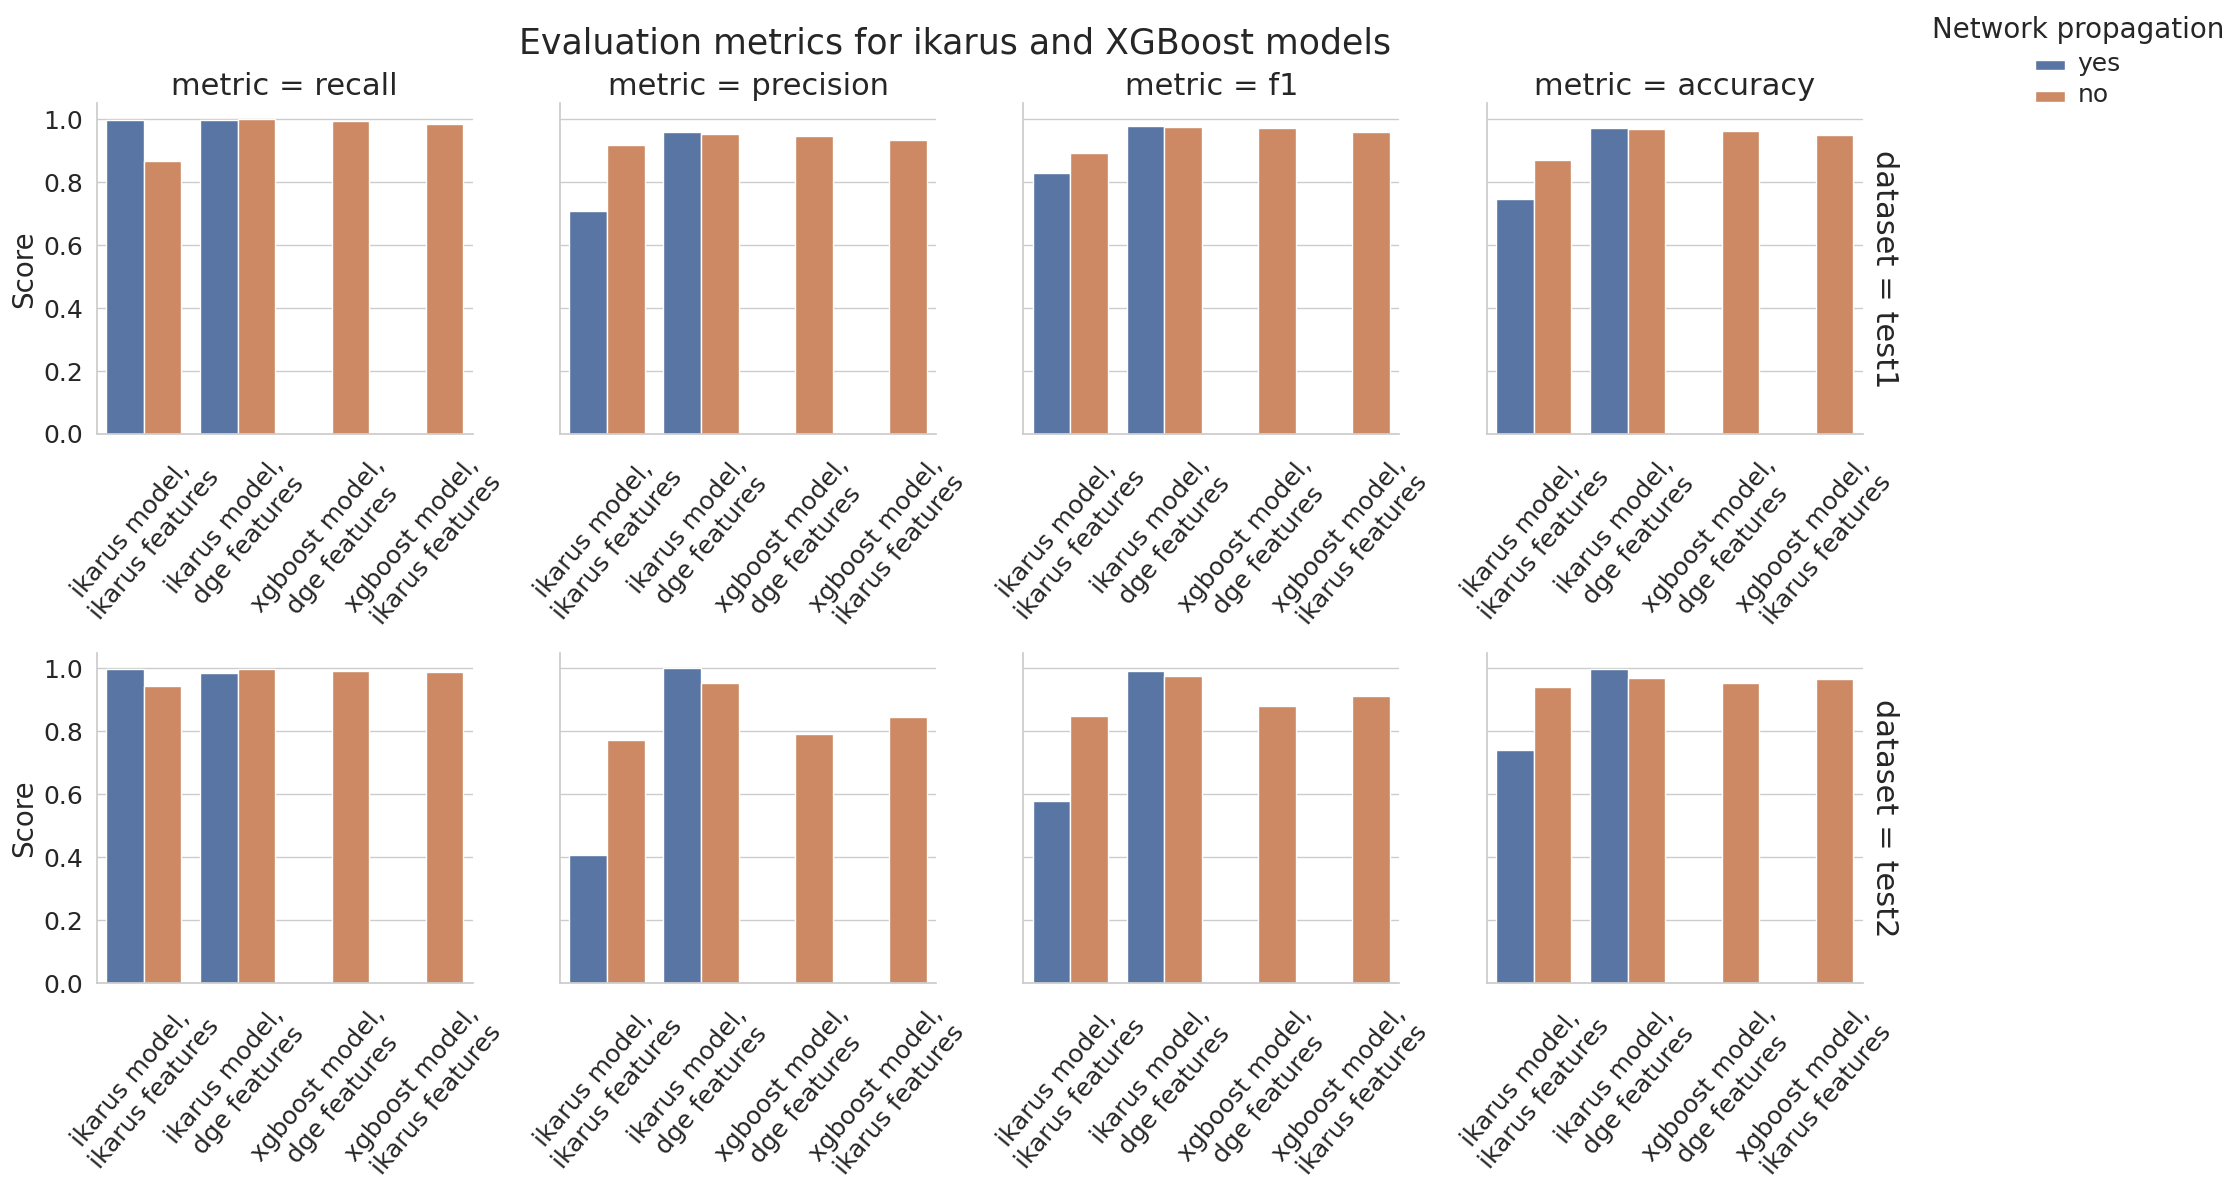

In [19]:
# Plot barplot, faceted by metric and dataset
sns.set_theme(style='whitegrid')
with sns.plotting_context(context = "notebook"):
    g1 = sns.catplot(
        data=metrics_df_tall,
        x='model_name', y='score', row = 'dataset', col='metric',
        hue = 'network_prop', kind='bar',
        sharex = False, height = 6, aspect = 0.75,
        margin_titles = True
    )

g1.set_xticklabels(rotation = 50, fontsize = 18)
g1.tick_params(axis='y', labelsize = 18)
g1.set_axis_labels('', 'Score', fontsize = 20)

g1.fig.suptitle('Evaluation metrics for ikarus and XGBoost models', fontsize = 25)
g1.set_titles(size = 22)

sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
g1.legend.get_title().set_text('Network propagation')
plt.setp(g1.legend.get_texts(), fontsize='18')
plt.setp(g1.legend.get_title(), fontsize='20')

g1.fig.tight_layout()

plt.show()

In [21]:
g1.savefig('metrics_ikarus_xgboost.png')